In [1]:
import numpy as np
import matplotlib.pylab as plt
import pickle
import tqdm as tq

In [2]:
def forward(m, S, b, A, Sigma, dt):
    
    for i in range(len(b) - 1):
        
        # Euler step for m and S ODEs
        m[i + 1] = m[i] - (np.dot(A[i], m[i]) - b[i]) * dt
        S[i + 1] = S[i] - (np.dot(A[i], S[i]) + np.dot(S[i], A[i].T) - Sigma) * dt
        
    return m, S

In [3]:
def backward(t_grid, A, b, m, S, Sigma, r, psi, lamda, t_dict, x, dt):
    
    # Arrays for storing the updates for A and b
    A_ = np.zeros_like(A)
    b_ = np.zeros_like(b)
    KL = 0
    
    for i in range(len(b) - 1, 0, -1):
        
        KL += 8 * ((m[i] ** 6) + 15 * (m[i] ** 4) * S[i] + 45 * (m[i] ** 2) * (S[i] ** 2) + 15 * (S[i] ** 6)) / Sigma \
                - 4 * (4 + A[i]) * (m[i] ** 4 + 6 * m[i] ** 2 * S[i] + 3 * S[i] ** 2) / Sigma \
                + 4 * b[i] * (m[i] ** 3 + 3 * m[i] * S[i]) / Sigma \
                + (4 * A[i]) ** 2 * (m[i] ** 2 + S[i]) * 0.5 / Sigma \
                - b[i] * (4 + A[i]) * m[i] / Sigma + b[i] ** 2 * 0.5 / Sigma
        
        # Compute dEdS and dEdm
        dEdS = 8 / Sigma * (15 * m[i] ** 4 + 90 * m[i] ** 2 * S[i] + 45 * S[i] ** 2) \
                - 4 * (4 + A[i]) / Sigma * (16 * m[i] ** 2 + 6 * S[i]) \
                + 12 * b[i] * m[i] / Sigma + 0.5 * (4 + A[i]) ** 2 / Sigma 
        
        dEdm = 8 / Sigma * (6 * m[i] ** 5 + 60 * S[i] * m[i] ** 3 + 90 * S[i] ** 2 * m[i]) \
                - 4 * (4 + A[i]) / Sigma * (4 * m[i] ** 3 + 12 * S[i] * m[i]) \
                + 4 * b[i] * (3 * m[i] ** 2 + 3 * S[i]) / Sigma + (4 + A[i]) ** 2 * m[i] /Sigma \
                - b[i] * (4 + A[i]) / Sigma
        
        # Euler step for lambda and psi ODEs
        lamda[i - 1] = lamda[i] - (np.dot(A[i].T, lamda[i]) - dEdm) * dt
        psi[i - 1] = psi[i] - (2 * np.dot(psi[i], A[i]) - dEdS) * dt
        
        # Handle jump conditions at locations of the data
        if t_grid[i - 1] in t_dict:
            psi[i - 1] = psi[i - 1] + 0.5 * r ** -2
            lamda[i - 1] = lamda[i - 1] - r ** -2 * (x[t_dict[t_grid[i - 1]]] - m[i - 1])
            
    for i in range(len(b) - 1, -1, -1):
        A_[i] = -4 * (1 - 3 * m[i] ** 2 - 3 * S[i]) + 2 * np.dot(Sigma, psi[i])
        b_[i] = -4 * (m[i] ** 3 + 3 * m[i] * S[i]) + 4 * m[i] + np.dot(A_[i], m[i]) - np.dot(Sigma, lamda[i])
        
    return psi, lamda, b_, A_, KL

In [4]:
def smoothing(t_obs, t_grid, y_obs, num_passes, omega, Sigma,  r, dt, m0, S0):
    
    grid_size = t_grid.shape[0]
    
    # Dictionary mapping from times to indices for array x
    t_dict = dict(zip(t_obs, np.arange(0, len(t_obs))))
    
    b = np.zeros((grid_size, 1))
    A = np.zeros((grid_size, 1, 1))
    KL_ = np.zeros(num_passes)
    
    for i in tq.tqdm(range(num_passes)):

        lamda = np.zeros((grid_size, 1))
        psi = np.zeros((grid_size, 1, 1))

        m = m0 * np.ones((grid_size, 1))
        S = S0 * np.ones((grid_size, 1, 1))
        
        # Forward pass to compute m, S
        m, S = forward(m=m, S=S, b=b, A=A, Sigma=Sigma, dt=dt)
        
        # Backward pass to compute psi, lamda, b_, A_
        psi, lamda, b_, A_, KL = backward(t_grid=t_grid,
                                      A=A,
                                      b=b,
                                      m=m,
                                      S=S,
                                      Sigma=Sigma,
                                      r=r,
                                      psi=psi,
                                      lamda=lamda,
                                      t_dict=t_dict,
                                      x=y_obs,
                                      dt=dt)
        KL_[i] = KL
        b = b + omega * (b_ - b)
        A = A + omega * (A_ - A)

    return b, A, m, S, psi, lamda, KL_

Load dataset

In [5]:
with open('EX02_DW', 'rb') as f:
    prior = pickle.load(f)
    likelihood = pickle.load(f)
    std = pickle.load(f)

In [6]:
def prior_drift (s, x_s):
    return 4 * x_s * (1 - (x_s ** 2))

In [7]:
true_sde_pts, true_sde_trj = prior[0], prior[1]
obs, obs_time = likelihood[0], likelihood[1]
sde_sigma, obs_sigma = std[0], std[1]

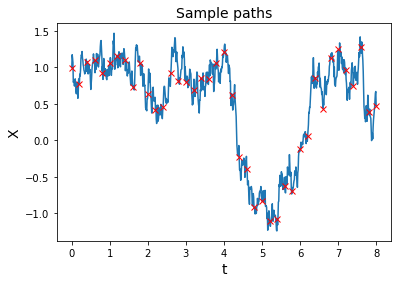

In [8]:
# Plot paths
plt.plot(true_sde_pts,true_sde_trj)
plt.plot(obs_time, obs, "rx")
plt.xlabel("t", fontsize=14)
plt.ylabel("X", fontsize=14)
plt.title("Sample paths", fontsize=14)
plt.show()


In [9]:
t_obs = obs_time.numpy()
y_obs = obs.numpy().flatten()

In [20]:
# Algorithm parameters
num_passes = 2000
Sigma = sde_sigma ** 2 * np.eye(1)
omega = 0.005 # If it is any higher than, the algorithm explodes
m0 = y_obs[0]
S0 = 0.04
t_grid = true_sde_pts.numpy()
grid_size = t_grid.shape[0]
dt = (true_sde_pts[1] - true_sde_pts[0]).item()
print(t_grid, grid_size, dt)

# Run the smoothing algorithm
b, A, m, S, psi, lamda, KL = smoothing(t_obs=t_obs,
                                   t_grid=t_grid,
                                   y_obs=y_obs,
                                   num_passes=num_passes,
                                   omega=omega,
                                   Sigma=Sigma,
                                   r=obs_sigma,
                                   dt=dt,
                                   m0=m0,
                                   S0=S0)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11
 1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23 1.24 1.25
 1.26 1.27 1.28 1.29 1.3  1.31 1.32 1.33 1.34 1.35 1.36 1.37 1.38 1.39
 1.4  1.41 1.42 1.43 1.44 1.45 1.46 1.47 1.48 1.49 1.5  1.51 1.52 1.53
 1.54 1.55 1.56 1.57 1.58 1.59 1.6  1.61 1.62 1.63 1.64 1.65 1.66 1.67
 1.68 1.69 1.7  1.71 1.72 1.73 1.74 1.75 1.76 1.77 1.78 1.79 1.8  1.81
 1.82 1.83 1.84 1.85 1.86 1.87 1.88 1.89 1.9  1.91 1.92 1.93 1.94 1.95
 1.96 

  0%|                                          | 1/2000 [00:00<04:27,  7.47it/s]/var/folders/2c/_gzbr1y51ws47zfknhxm868h0000gr/T/ipykernel_20740/2009803428.py:7: RuntimeWarning: overflow encountered in add
  S[i + 1] = S[i] - (np.dot(A[i], S[i]) + np.dot(S[i], A[i].T) - Sigma) * dt
/var/folders/2c/_gzbr1y51ws47zfknhxm868h0000gr/T/ipykernel_20740/2009803428.py:7: RuntimeWarning: invalid value encountered in subtract
  S[i + 1] = S[i] - (np.dot(A[i], S[i]) + np.dot(S[i], A[i].T) - Sigma) * dt
/var/folders/2c/_gzbr1y51ws47zfknhxm868h0000gr/T/ipykernel_20740/2009803428.py:6: RuntimeWarning: invalid value encountered in subtract
  m[i + 1] = m[i] - (np.dot(A[i], m[i]) - b[i]) * dt
/var/folders/2c/_gzbr1y51ws47zfknhxm868h0000gr/T/ipykernel_20740/3284926341.py:10: RuntimeWarning: overflow encountered in power
  KL += 8 * ((m[i] ** 6) + 15 * (m[i] ** 4) * S[i] + 45 * (m[i] ** 2) * (S[i] ** 2) + 15 * (S[i] ** 6)) / Sigma \
/var/folders/2c/_gzbr1y51ws47zfknhxm868h0000gr/T/ipykernel_20740/3284926

  1%|▏                                        | 11/2000 [00:01<04:37,  7.16it/s]


KeyboardInterrupt: 

/var/folders/2c/_gzbr1y51ws47zfknhxm868h0000gr/T/ipykernel_20740/3656545120.py:10: RuntimeWarning: invalid value encountered in sqrt
  m[:, 0] - S[:, 0, 0] ** 0.5,
/var/folders/2c/_gzbr1y51ws47zfknhxm868h0000gr/T/ipykernel_20740/3656545120.py:11: RuntimeWarning: invalid value encountered in sqrt
  m[:, 0] + S[:, 0, 0] ** 0.5,


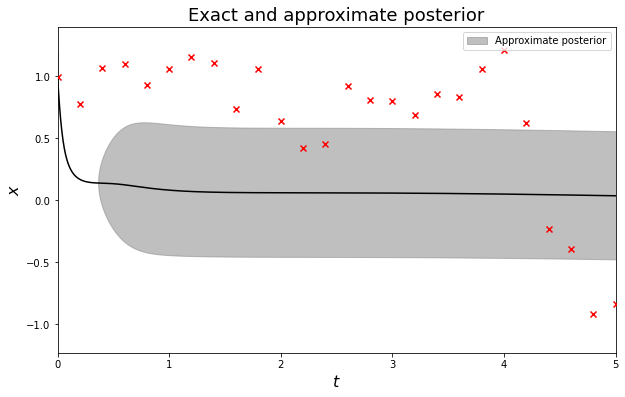

In [13]:

# Plot data, approximate and exact posterior
plt.figure(figsize=(10, 6))

# Observed data
plt.scatter(t_obs, y_obs, marker='x', color='red', zorder=3)

# Approximate posterior
plt.plot(t_grid, m[:, 0], color='black', zorder=2)
plt.fill_between(t_grid,
                 m[:, 0] - S[:, 0, 0] ** 0.5,
                 m[:, 0] + S[:, 0, 0] ** 0.5,
                 color='gray',
                 alpha=0.5,
                 zorder=1,
                 label='Approximate posterior')

# Format plot
plt.title('Exact and approximate posterior', fontsize=18)
plt.xlabel('$t$', fontsize=16)
plt.ylabel('$x$', fontsize=16)
plt.xticks(np.linspace(0, 5, 6))
plt.yticks(np.linspace(-1, 1, 5))
plt.xlim([0, 5])
plt.legend()
plt.show()

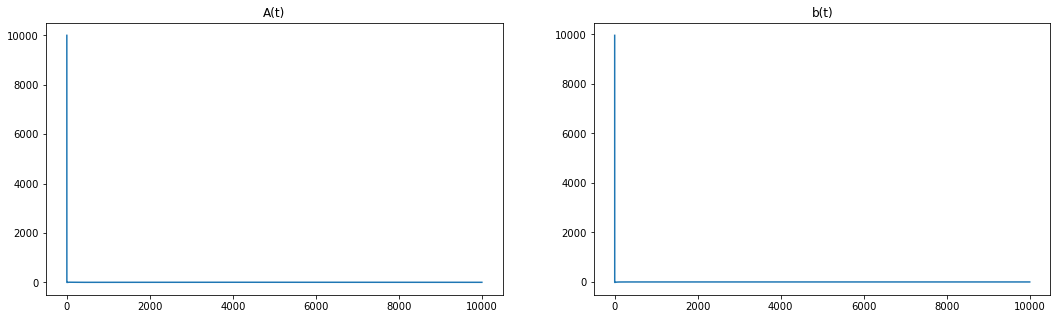

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
ax[0].plot(A.flatten())
ax[0].set_title("A(t)")
ax[1].plot(b.flatten())
ax[1].set_title("b(t)")
plt.show()

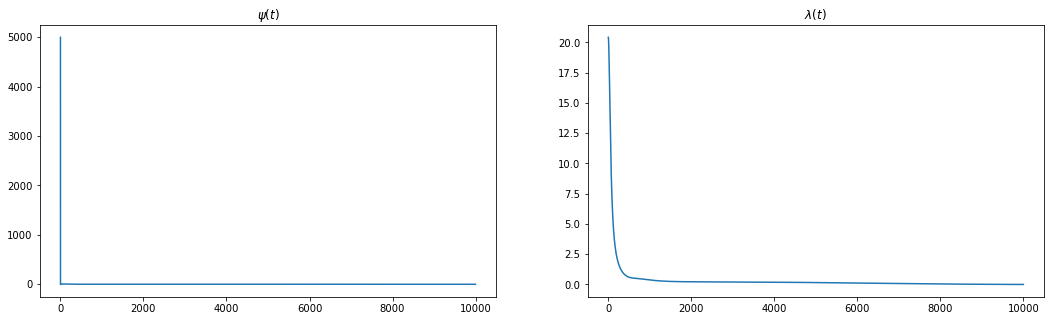

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
ax[0].plot(psi.flatten())
ax[0].set_title(r"$\psi(t)$")
ax[1].plot(lamda.flatten())
ax[1].set_title(r"$\lambda(t)$")
plt.show()

Text(0, 0.5, 'KL divergence')

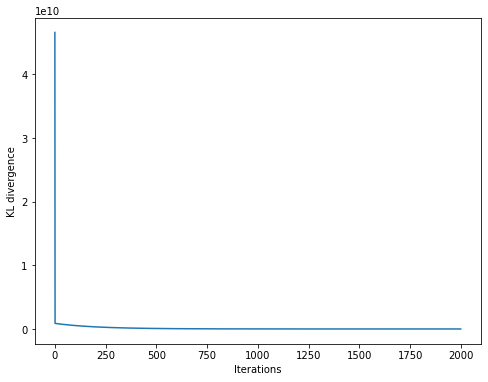

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(KL.shape[0]), KL)
plt.xlabel("Iterations")
plt.ylabel("KL divergence")